# Advanced Machine Learning - programming assignment 1

**Please fill in:**
* name 1 (student id 1)
* name 2 (student id 2)
* name 3 (student id 3)

## Structural causal models
In this programming assignment, we will look at data from a structural causal model, and see how we can estimate the causal effect of $X$ on $Y$ from these data. The model consists of three variables:

* $X$ is the treatment: the dosage of a drug taken by a patient;
* $Y$ is the outcome: a numerical score reflecting how well the patient recovered;
* $Z$ is an additional variable that summarizes relevant genetic information about a patient.

$Y$ and $Z$ are continuous (real-valued), while $X$ is discrete.

The following code generates and plots observational data from this model.

In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt

# Generate data from the observational distribution
def f_Z(num_samples):
    return 4 * np.random.random(size=num_samples) + 4 * np.random.random(size=num_samples)
def f_X(z, num_samples):
    x_cont = z + np.random.normal(loc=0.0, scale=1.0, size=num_samples)
    return np.clip(2 * np.around(0.5 * (x_cont)), 0, 10).astype(dtype=int)
def f_Y(z, x, num_samples):
    return 2*z - x + np.random.normal(loc=0.0, scale=0.4, size=num_samples)
def generate_observational_data(num_samples):
    z = f_Z(num_samples)
    x = f_X(z, num_samples)
    y = f_Y(z, x, num_samples)
    return (x, y, z)

num_samples_obs = 1000

x, y, z = generate_observational_data(num_samples_obs)

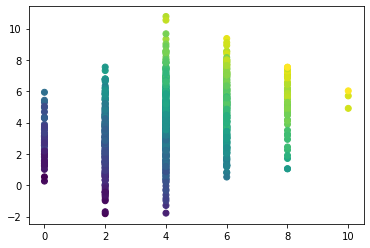

In [2]:
plt.scatter(x, y, c=z)
plt.show()

With any supervised learning method of your choice, predict y using x as the only feature. Make a new plot that displays both the data and your prediction curve.

In [3]:
# Your code here

Now we will consider what happens if we intervene on the system by prescribing certain dosages of the drug. Complete the following function.

In [4]:
def generate_experimental_data(x, num_samples):
    # Generate data under intervention do(X=x[i]). x is a vector of length num_samples.
    # Your code here
    # return (x, y, z)
    return (x, x, x) # temporary

We will look at interventional data where for each data point, the dosage is chosen uniformly at random from the set {0,2,4,8}, independently for each individual.

In [5]:
num_samples_exp = 200

#x_int = 10 * np.random.random(size=num_samples_exp)
x_exp = np.random.choice(np.array([0, 2, 4, 8], dtype=int), size=num_samples_exp)
(x_exp, y_exp, z_exp) = generate_experimental_data(x_exp, num_samples_exp)

Plot these experimental data in the same way as before, again with your prediction curve in the same plot.

In [6]:
# Your code here

Compute the RMSE (root mean squared error) when you use the predictor you learned earlier to predict y in these new data.

In [7]:
# Your code here

**Question:** What (marginal or conditional) independence should hold in the experimental data, based on d-separation? Plot the data in a way that illustrates this independence, and explain what property of the plot illustrates the independence.

*Your answer here*

In [8]:
# Your code here

Now, we will use the method of Inverse Probability Weighing (section 3.6 in the book) for this task. Using *only the observational data*, fit a logistic regression to predict x using z as a feature. From this logistic regression, extract estimates for $P(X=x|Z=z)$. Use these to compute an inverse probability weight for each data point in the observational data set.

In [9]:
# Create logistic regression object
reg_logistic = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)

# Your code here

Now again predict y in terms of x using only the observational data as training data, but this time weight each data point with the inverse probability weight. Plot your regression curve in the same plot as the experimental data, as before.

In [10]:
# Your code here

To verify that these predictions of the causal effect of X on Y are more accurate, again compute the RMSE on the experimental data.

In [11]:
# Your code here

You are done! Before handing in, use Kernel > Restart & run all. This makes sure that the code you hand in works, and that all plots are shown. Submit just one file per team.